In [2]:
period=-1200
time_interval='1d'

%run stock_data_loader.ipynb

yfinance version: 0.2.50
Start load stock data with interval: 1d


[*********************100%***********************]  501 of 501 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 826 entries, 2021-08-19 to 2024-11-29
Columns: 3006 entries, ('A', 'Adj Close') to ('ZTS', 'Volume')
dtypes: float64(2513), int64(493)
memory usage: 18.9 MB
Download stock data completed


In [3]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import plotly.express as px
import warnings
from scipy import stats
import statsmodels.api as sm

%run file_loader.ipynb

## Загрузка данных

In [4]:
stock_tickers = ['AAPL', 'EBAY', 'MSFT', 'PYPL', 'AMZN', 'NFLX', 'GOOG']
dir = "stock_data"
stock_data = {};
stock_df = pd.DataFrame()
for name in stock_tickers:
    f = os.path.join(dir, name+'.csv')
    if os.path.isfile(f):
        df = loading(f, name)
        if stock_df.empty:
            stock_df = df
        else:
            stock_df = stock_df.merge(df, on='date', how='outer')
stock_df = stock_df.sort_values('date').reset_index(drop=True)
stock_df = stock_df.set_index('date')

stock_df.tail(5)

,AAPL,AAPL_vol,AAPL_chg,AAPL_vol_chg,EBAY,EBAY_vol,EBAY_chg,EBAY_vol_chg,MSFT,MSFT_vol,...,AMZN_chg,AMZN_vol_chg,NFLX,NFLX_vol,NFLX_chg,NFLX_vol_chg,GOOG,GOOG_vol,GOOG_chg,GOOG_vol_chg
date,,,,,,,,,,,,,,,,,,,,,
2024-11-22,229.869995,38168300,0.59,-9.36,63.240002,3104500,2.98,-12.00,417.000000,24814600,...,-0.64,-46.38,897.789978,3214000,0.03,-28.76,166.570007,24497000,-1.58,-36.93
2024-11-25,232.869995,90152800,1.31,136.20,64.989998,7571700,2.77,143.89,418.790009,27691100,...,2.20,29.03,865.590027,6014200,-3.59,87.13,169.429993,21395700,1.72,-12.66
2024-11-26,235.059998,45986200,0.94,-48.99,65.089996,3192600,0.15,-57.84,427.989990,23458900,...,3.18,2.43,872.599976,3138300,0.81,-47.82,170.619995,14937500,0.70,-30.18
2024-11-27,234.929993,33498400,-0.06,-27.16,64.309998,2818600,-1.20,-11.71,422.989990,18332400,...,-1.02,-32.66,877.340027,2578200,0.54,-17.85,170.820007,12433400,0.12,-16.76
2024-11-29,237.330002,28481400,1.02,-14.98,63.290001,3266400,-1.59,15.89,423.459991,16271900,...,1.05,-11.29,886.809998,2027200,1.08,-21.37,170.490005,9250700,-0.19,-25.60


In [5]:
# validate null
stock_df.isnull().sum()

AAPL            0
AAPL_vol        0
AAPL_chg        0
AAPL_vol_chg    0
EBAY            0
EBAY_vol        0
EBAY_chg        0
EBAY_vol_chg    0
MSFT            0
MSFT_vol        0
MSFT_chg        0
MSFT_vol_chg    0
PYPL            0
PYPL_vol        0
PYPL_chg        0
PYPL_vol_chg    0
AMZN            0
AMZN_vol        0
AMZN_chg        0
AMZN_vol_chg    0
NFLX            0
NFLX_vol        0
NFLX_chg        0
NFLX_vol_chg    0
GOOG            0
GOOG_vol        0
GOOG_chg        0
GOOG_vol_chg    0
dtype: int64

In [6]:
stock_df = stock_df.dropna()

In [7]:
## last year
stock_df[-360:].describe()

,AAPL,AAPL_vol,AAPL_chg,AAPL_vol_chg,EBAY,EBAY_vol,EBAY_chg,EBAY_vol_chg,MSFT,MSFT_vol,...,AMZN_chg,AMZN_vol_chg,NFLX,NFLX_vol,NFLX_chg,NFLX_vol_chg,GOOG,GOOG_vol,GOOG_chg,GOOG_vol_chg
count,360.000000,3.600000e+02,360.000000,360.000000,360.000000,3.600000e+02,360.000000,360.000000,360.000000,3.600000e+02,...,360.000000,360.000000,360.000000,3.600000e+02,360.000000,360.000000,360.000000,3.600000e+02,360.000000,360.000000
mean,196.495778,5.719988e+07,0.073861,5.423417,50.062639,5.560451e+06,0.111583,6.348028,391.511278,2.222779e+07,...,0.148806,4.946917,570.959333,4.331473e+06,0.230778,7.616000,152.213861,2.044515e+07,0.114472,5.497472
std,21.230551,2.684593e+07,1.368146,39.174664,7.898829,3.173948e+06,1.645897,42.916670,40.775230,8.745682e+06,...,1.820612,34.139560,127.587976,3.189167e+06,2.075046,46.206311,18.948329,8.262113e+06,1.703245,38.126291
min,165.000000,2.404830e+07,-4.820000,-83.010000,37.990002,2.606500e+06,-10.530000,-84.620000,312.140015,9.932800e+06,...,-8.780000,-65.790000,346.190002,1.354200e+06,-9.090000,-64.240000,116.870003,7.409100e+06,-9.600000,-69.530000
25%,178.817505,4.362628e+07,-0.700000,-17.880000,43.137500,3.991875e+06,-0.882500,-17.272500,356.167496,1.689718e+07,...,-0.872500,-16.072500,445.864998,2.722325e+06,-0.750000,-22.360000,136.394997,1.546762e+07,-0.882500,-18.257500
50%,190.589996,5.152030e+07,0.150000,-1.895000,50.170000,4.852000e+06,0.155000,-0.255000,407.510010,2.026240e+07,...,0.070000,-0.465000,597.329987,3.521050e+06,0.195000,-1.995000,149.844994,1.826995e+07,0.330000,-0.010000
75%,220.150002,6.273545e+07,0.792500,18.692500,54.557500,6.280175e+06,1.032500,20.255000,421.462502,2.484055e+07,...,1.182500,19.135000,666.582520,4.795600e+06,1.215000,25.310000,168.399994,2.231468e+07,1.015000,20.700000
max,237.330002,3.186799e+08,7.260000,377.200000,67.169998,4.348320e+07,7.880000,382.550000,467.559998,7.847820e+07,...,8.270000,153.850000,897.789978,2.807440e+07,16.050000,279.100000,192.660004,5.972800e+07,9.970000,256.520000


## Summary
1. Разница между средним и матожиданием(50% квантиль). 
   Цена бумаг за год торговалась ниже среднего, за исключением microsoft
2. За последний год почти по всем бумагам не сильно менялась, хотя 2 доллара на больших обьемах ощутимо
3. Сюдя по графику у PYPL дела не очень
3. Видимо на MSFT в краткосрочном горизонте можно было заработать

In [8]:
colors = ['blue', 'orange', 'green', 'red', 'Purple', 'Pink', 'Orange']

## Matplotlib

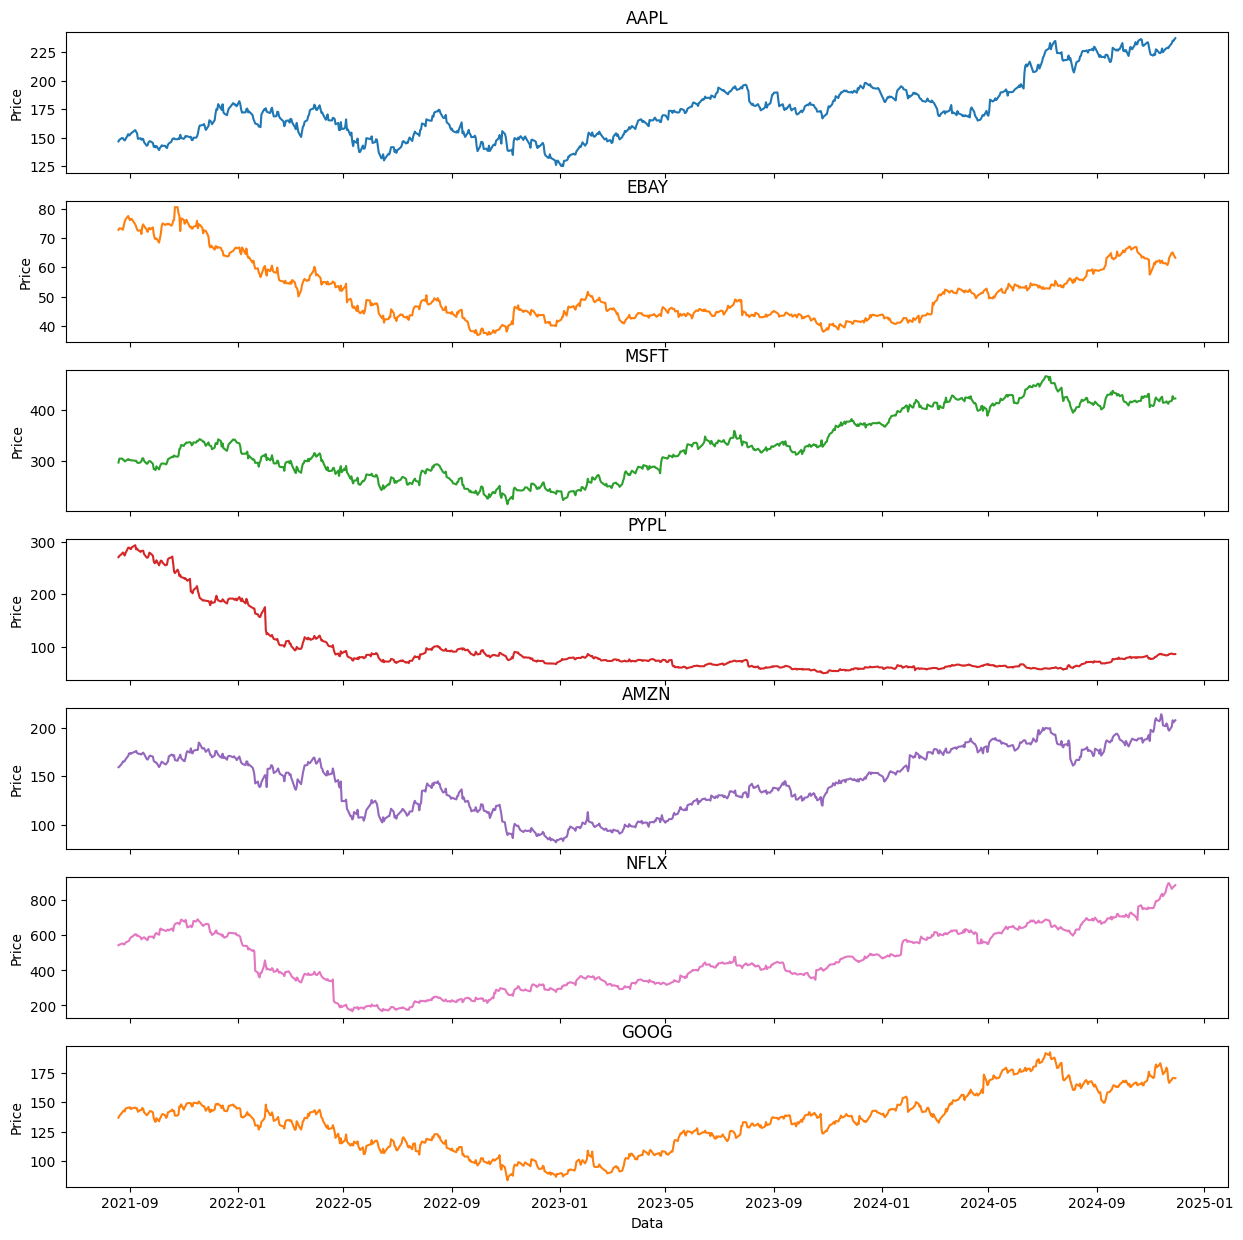

In [9]:
fig, axs = plt.subplots(len(stock_tickers), 1, figsize=(15,15))
ind = 0
for i in range(len(stock_tickers)):
    column = stock_tickers[ind]
    color = colors[ind]
    axs[i].plot(stock_df.index, stock_df[column], color=f'tab:{color}' )
    axs[i].set_title(column)
    ind += 1

for ax in axs.flat:
    ax.set(xlabel='Data', ylabel='Price')

for ax in axs.flat:
    ax.label_outer()

plt.show()

## Plotly

In [10]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=len(stock_tickers), cols=1,
    subplot_titles=stock_tickers)

ind = 0
for i in range(1,len(stock_tickers) + 1):
    column = stock_tickers[ind]
    color = colors[ind]
    fig.add_trace(go.Scatter(x=stock_df.index, y=stock_df[column], name=column), row=i, col=1)
    ind += 1

fig.show()

## Выводы

На графиках, за исключением paypal, выглядят похожими.

In [11]:
# plotly
fig = make_subplots(rows=len(stock_tickers), cols=1, subplot_titles=stock_tickers)

ind = 0
for i in range(1,len(stock_tickers) + 1):
    column = stock_tickers[ind]
    color = colors[ind]
    fig.add_trace(go.Scatter(x=stock_df.index, y=stock_df[column+'_chg'], name=column), row=i, col=1)
    ind += 1

fig.show()

## Выводы
Вроде как доходность в течении года составлял от 5-10%, не уверен что правильно понял

# Гистограмы распределения ежедневных доходов

array([[<Axes: title={'center': 'AAPL_chg'}>,
        <Axes: title={'center': 'EBAY_chg'}>,
        <Axes: title={'center': 'MSFT_chg'}>],
       [<Axes: title={'center': 'PYPL_chg'}>,
        <Axes: title={'center': 'AMZN_chg'}>,
        <Axes: title={'center': 'NFLX_chg'}>],
       [<Axes: title={'center': 'GOOG_chg'}>, <Axes: >, <Axes: >]],
      dtype=object)

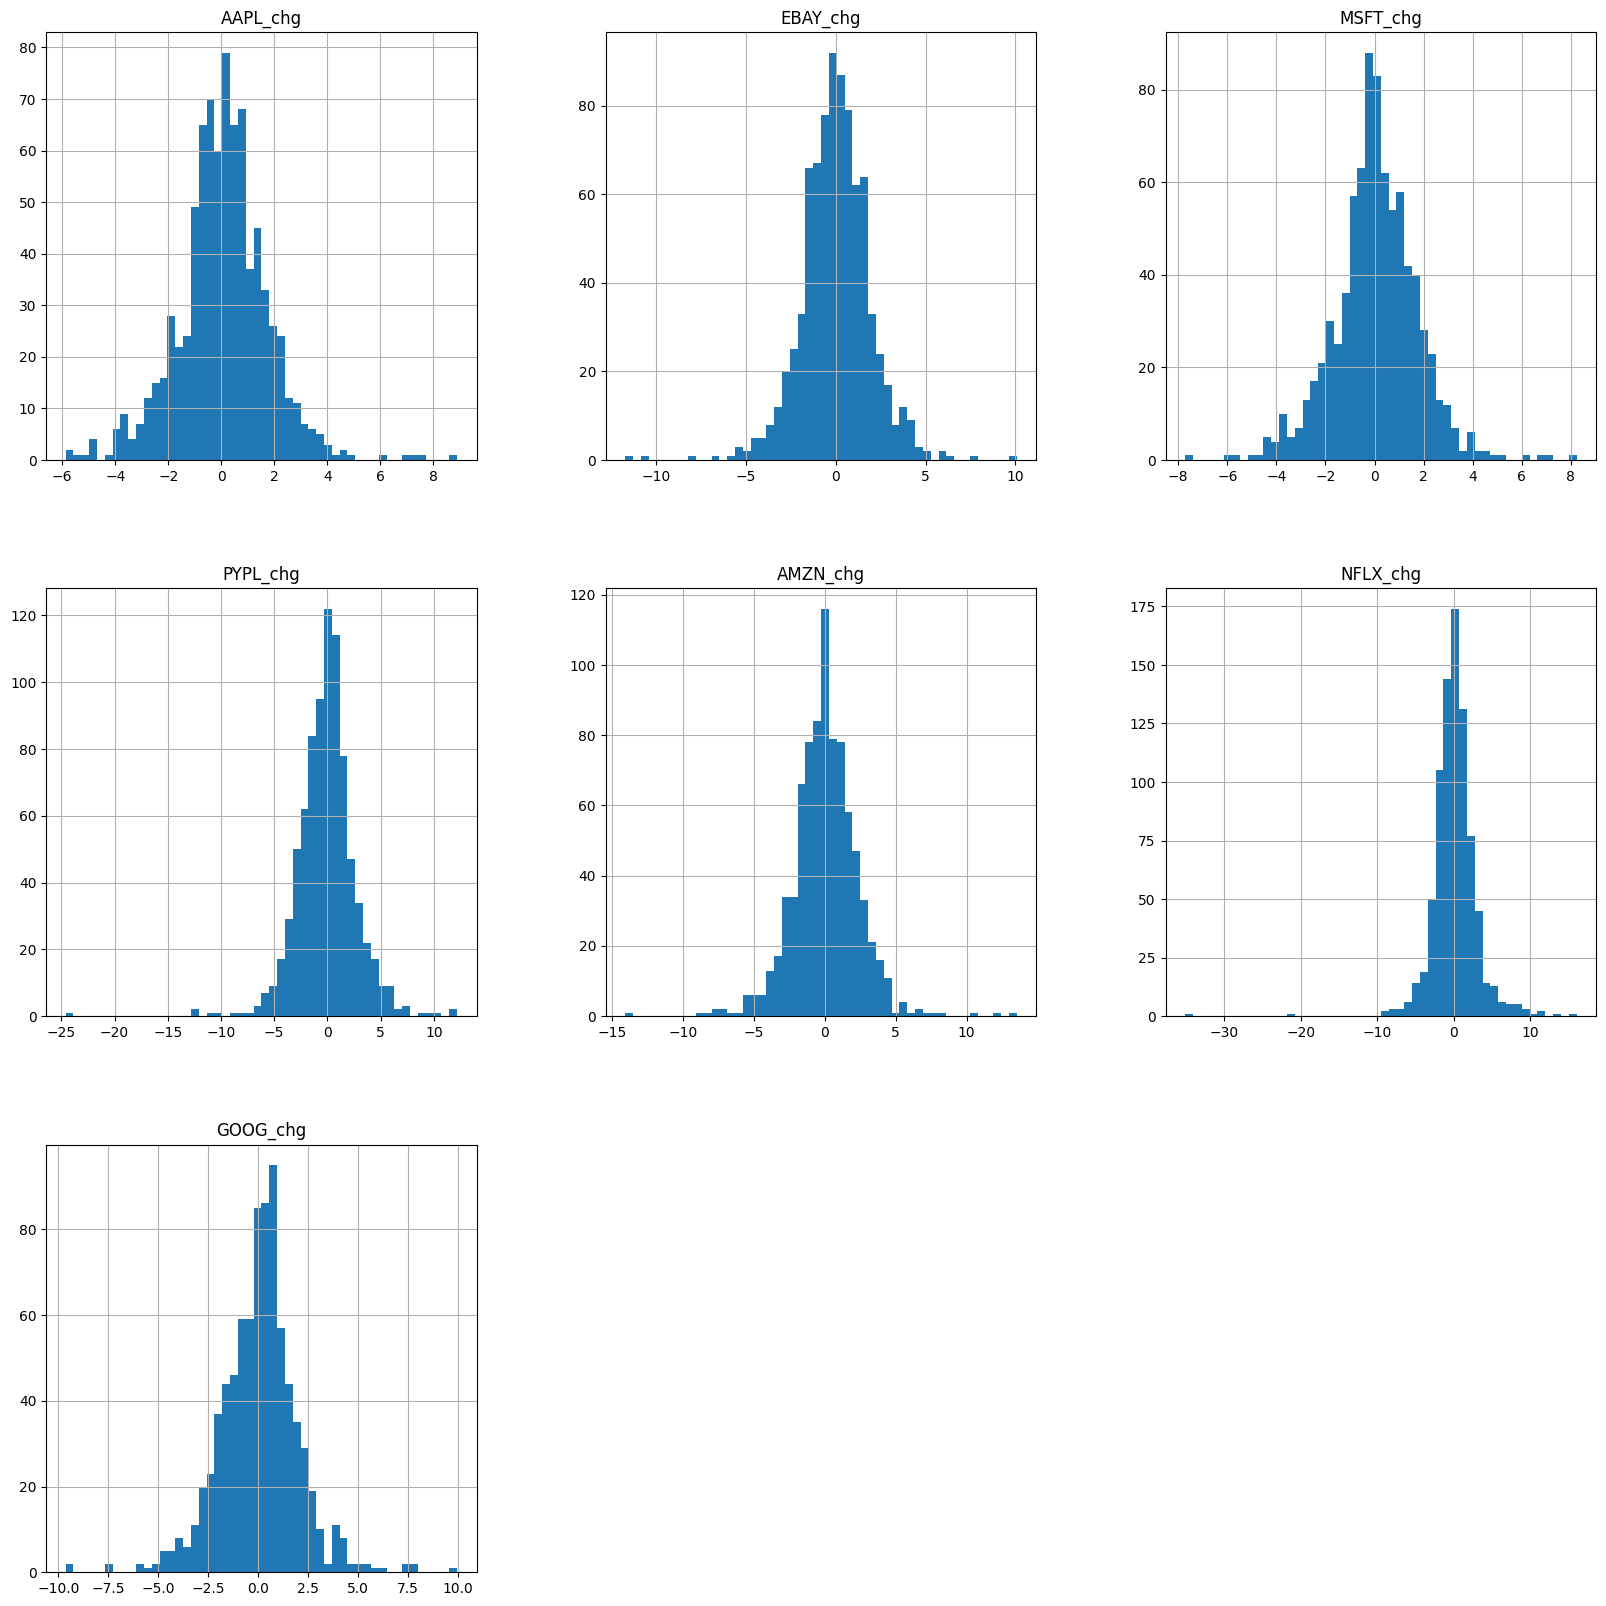

In [12]:
stock_df[[col + '_chg' for col in stock_tickers]].hist(bins = 50, figsize=(20, 20))

# Вывод
Гистограммы ежедневных доходностей центрированы вокруг среднего значения и имеют нормально распределение.


In [13]:
## Test
stat, p = stats.normaltest(stock_df['AAPL_vol_chg'])
print(f'stat={stat}, p={p}')
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=615.109428354873, p=2.6957818773933535e-134
Probably not Gaussian


In [14]:
stat, p = stats.normaltest(np.log(stock_df['AAPL_vol_chg'] + 80))
print(f'stat={stat}, p={p}')
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=nan, p=nan
Probably not Gaussian


/home/alex/workspaces/ML/wrk/hw1/otus/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



# Seaborn pairplot

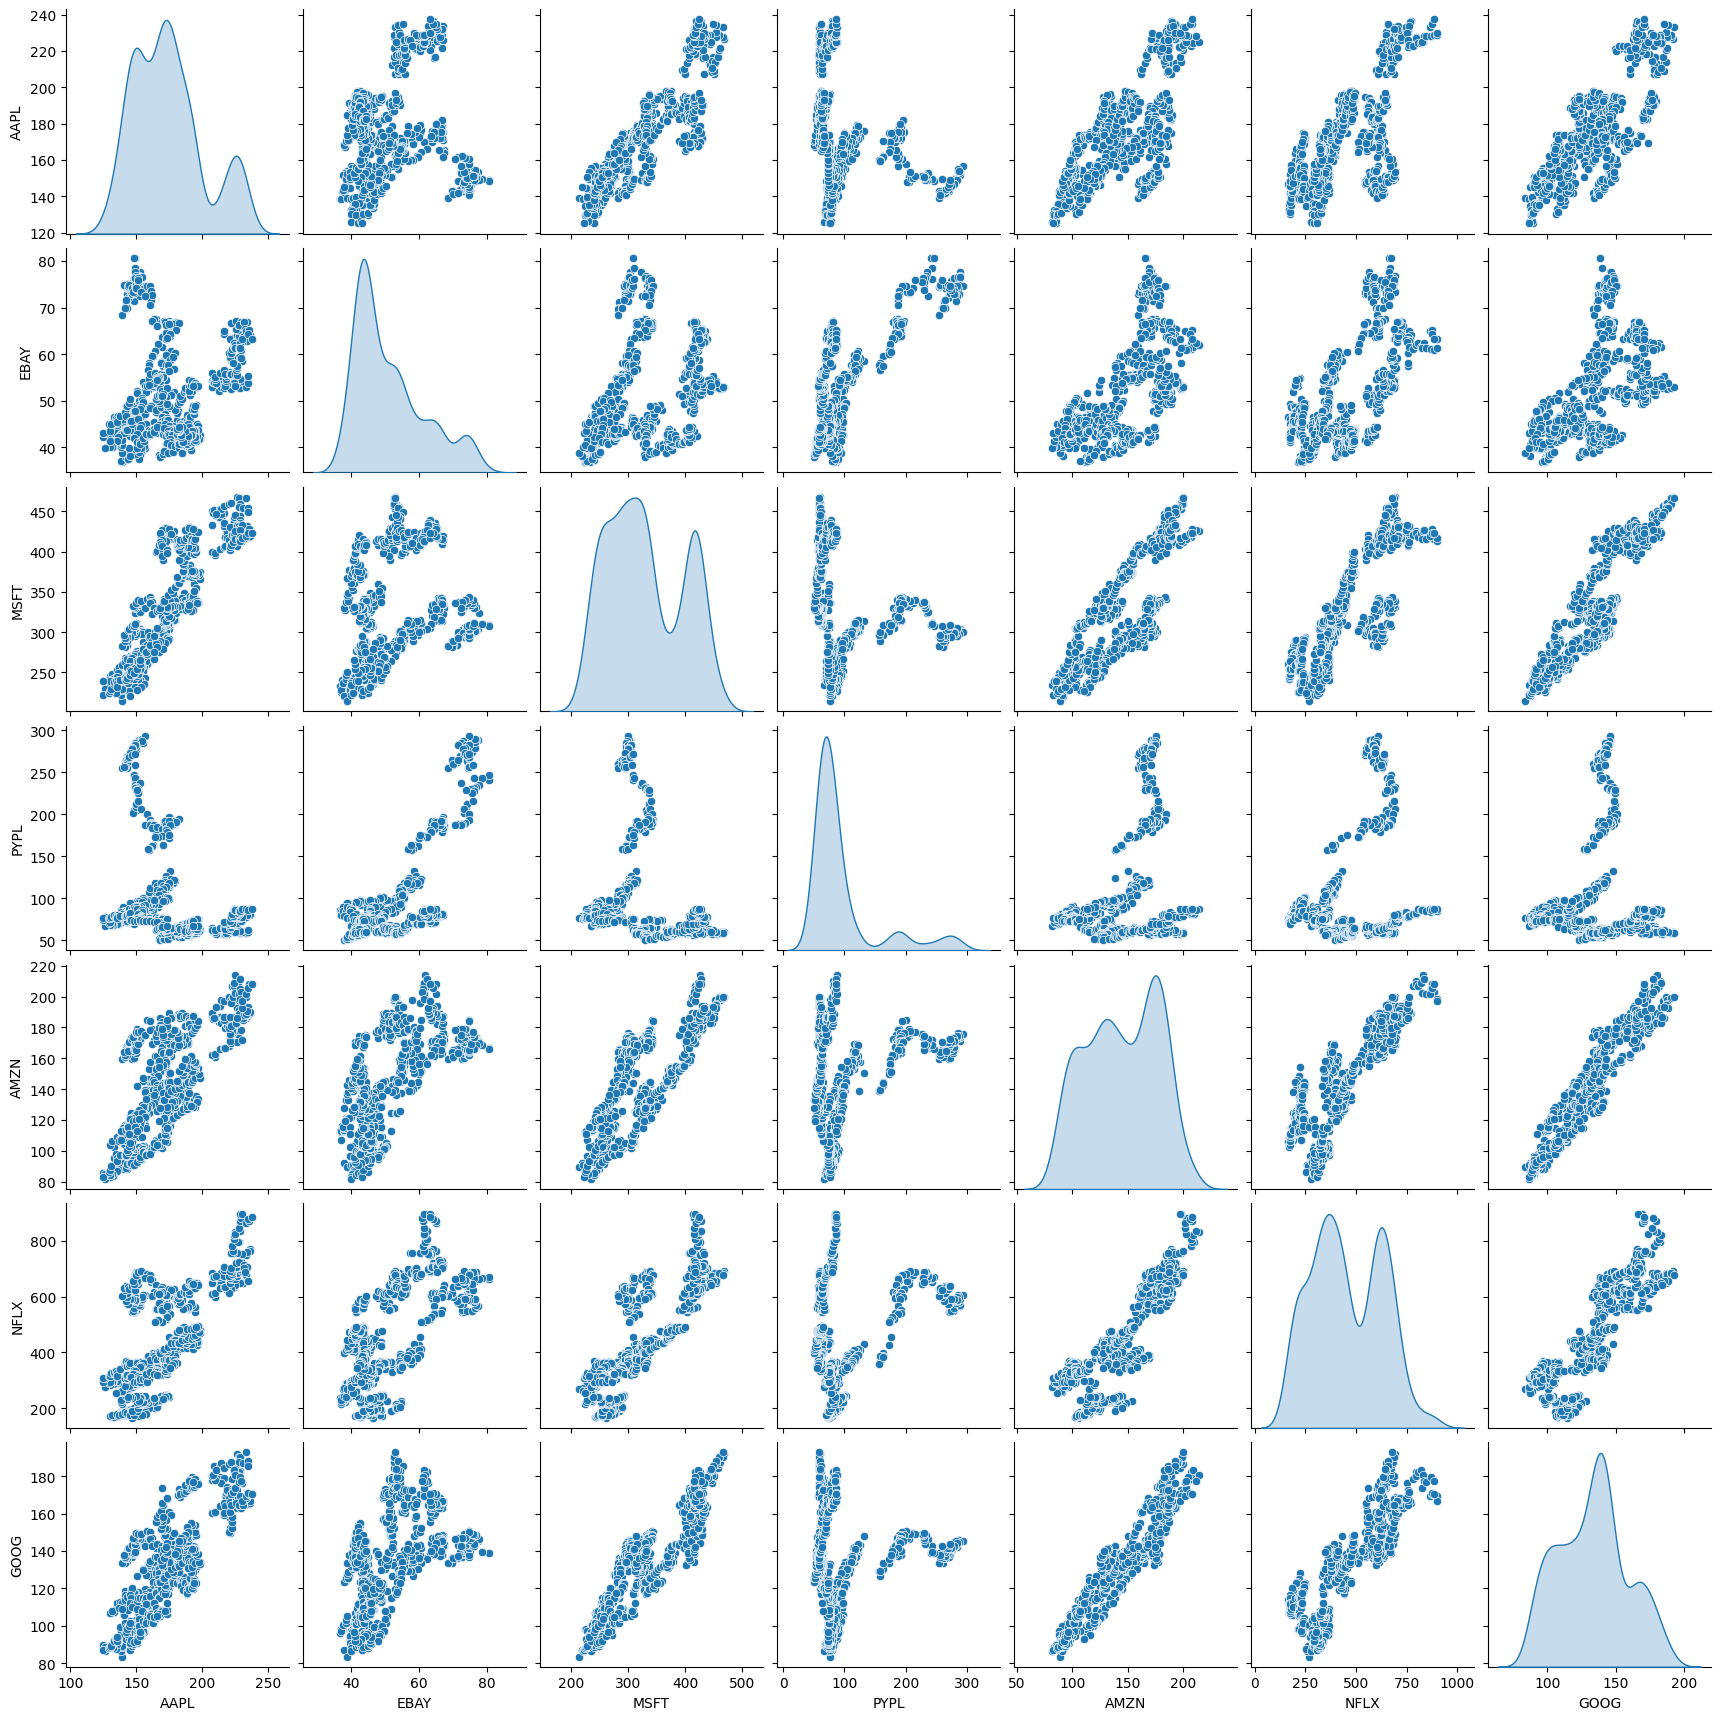

In [15]:
seaborn.pairplot(stock_df[[col for col in stock_tickers]], diag_kind="kde")

In [16]:
## plotly
fig = px.histogram(stock_df, x='AAPL_vol_chg', marginal="violin",)
# fig = px.histogram(stock_df, x='AAPL_vol_chg', marginal="rug",)
fig.show()

## Преобразование бокса кокса
Данное преобразование позволяет уменьшить влияние выбросов

In [17]:
stock_df['boxcox_AAPL_chg'] = stats.boxcox(x=(stock_df['AAPL_chg'] - stock_df['AAPL_chg'].min() + 1))[0]

# plotly
fig = px.histogram(stock_df, x='boxcox_AAPL_chg', marginal="violin",)
# fig = px.histogram(stock_df, x='boxcox_AAPL_chg', marginal="rug",)

fig.show()

# Корреляция
Так как наши распределения все же не нормальные, то будем использовать корреляцию Спирмана для получения информации о линейных связях

<Axes: >

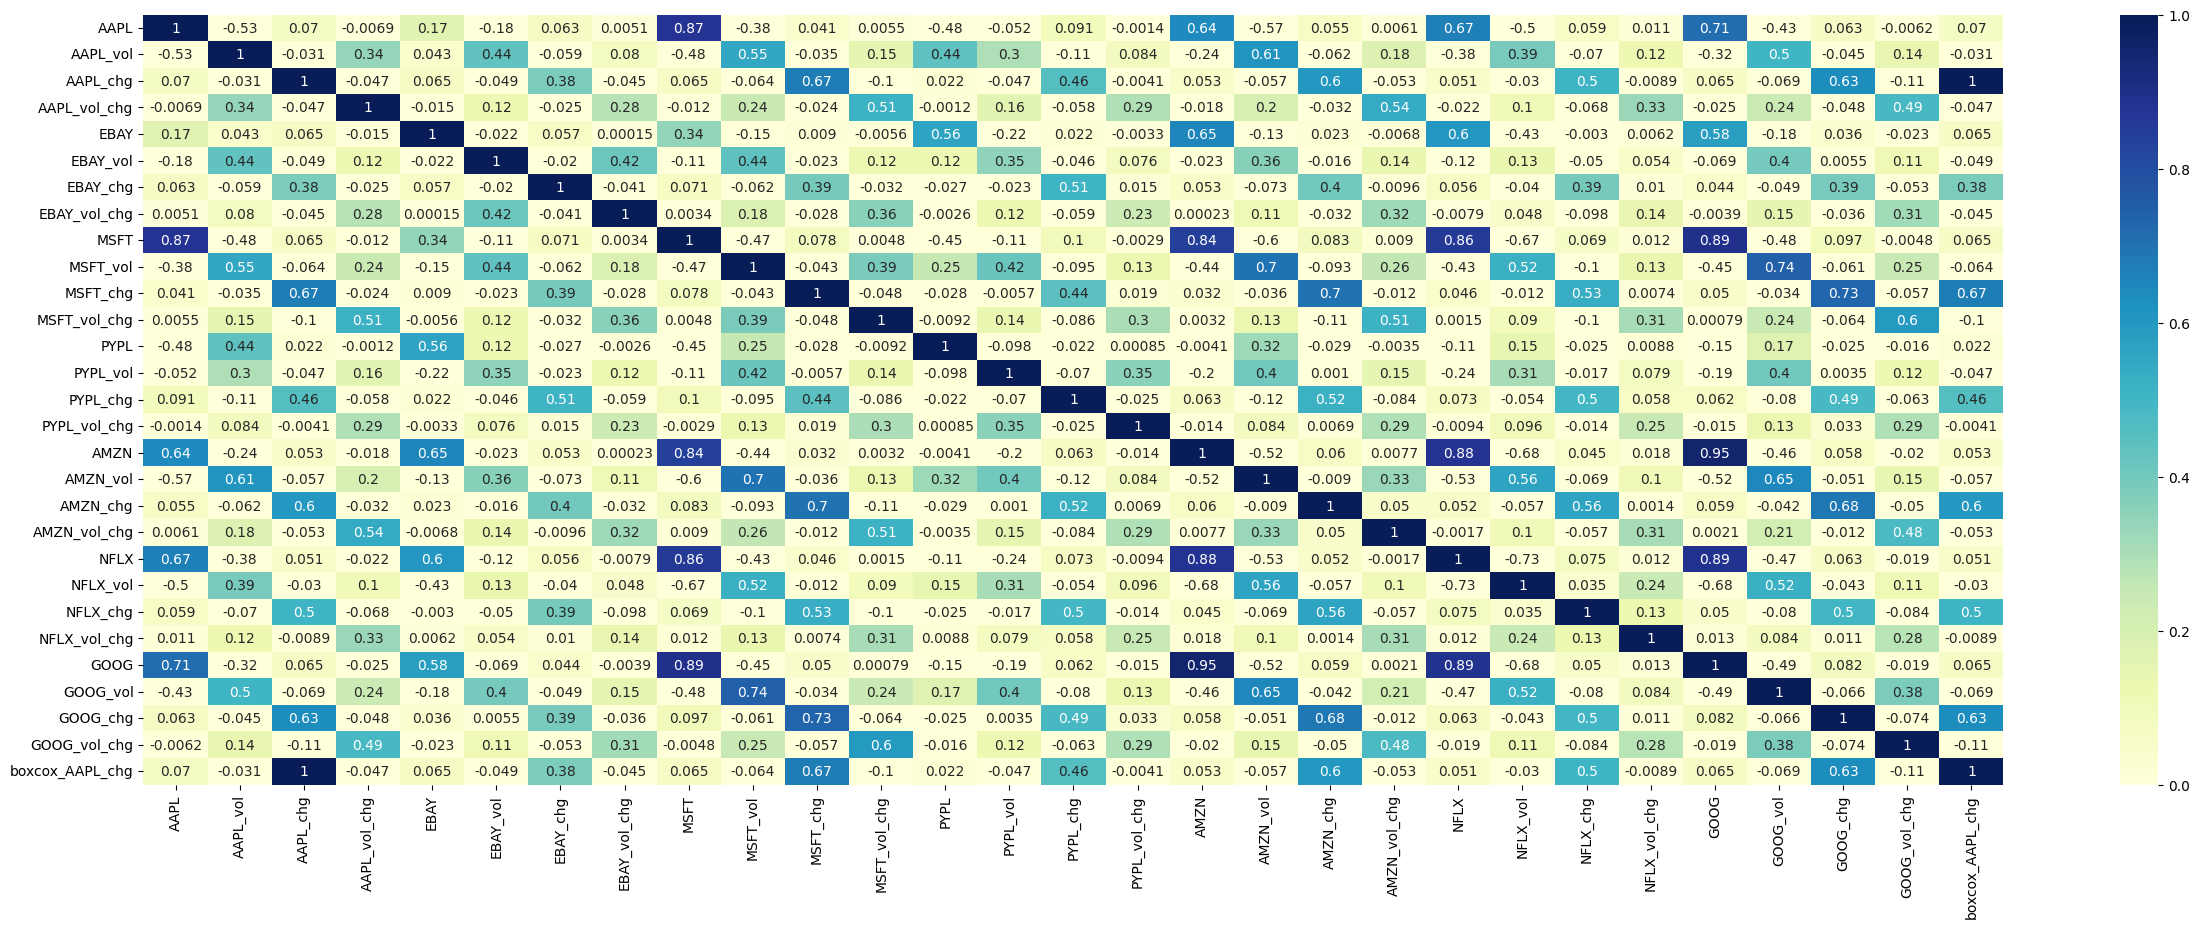

In [18]:
plt.figure(figsize=(30,10))
seaborn.heatmap(stock_df.corr(method='spearman', numeric_only=True), vmin=0, vmax=1, cmap='YlGnBu', annot=True)

# Вывод

# Проанализируем тренды

Оценим как менялся тренд у бумаг

In [19]:
stock_trend = stock_df[[col+ '_chg' for col in stock_tickers]]

def trend(x):
    if x > -5 and x <= 5:
        return 'Не менялся'
    elif x > 5 and x <= 15:
        return 'Небольшое увеличение'
    elif x > -15 and x <= -5:
        return 'Небольшой уменьшение'
    elif x > 15 and x <= 25:
        return 'увеличение'
    elif x > -25 and x <= -15:
        return 'уменьшение'
    elif x > 25 and x <= 50:
        return 'Значительное увеличение'
    elif x > -50 and x <= -25:
        return 'Значительное уменьшение'
    elif x > 50:
        return 'Максимальное увеличение'
    elif x <= -50:
        return 'Максимальное уменьшение'

for stock in stock_trend.columns:
    stock_trend['Trend_'+stock] = stock_trend[stock].apply(lambda x:trend(x))

# stock_trend

/tmp/ipykernel_4536/3442272972.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4536/3442272972.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4536/3442272972.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4

In [20]:
trend_columns = [col for col in stock_trend.columns if 'Trend_' in col]
ind = 0

for i in range(len(trend_columns)):
    column = trend_columns[ind]
    data_to_plot = stock_trend[column].value_counts().round(3)
    fig = px.pie(values=data_to_plot, names=data_to_plot.index)
    fig.update_layout(title=column)
    fig.show()
    ind += 1

## Additional

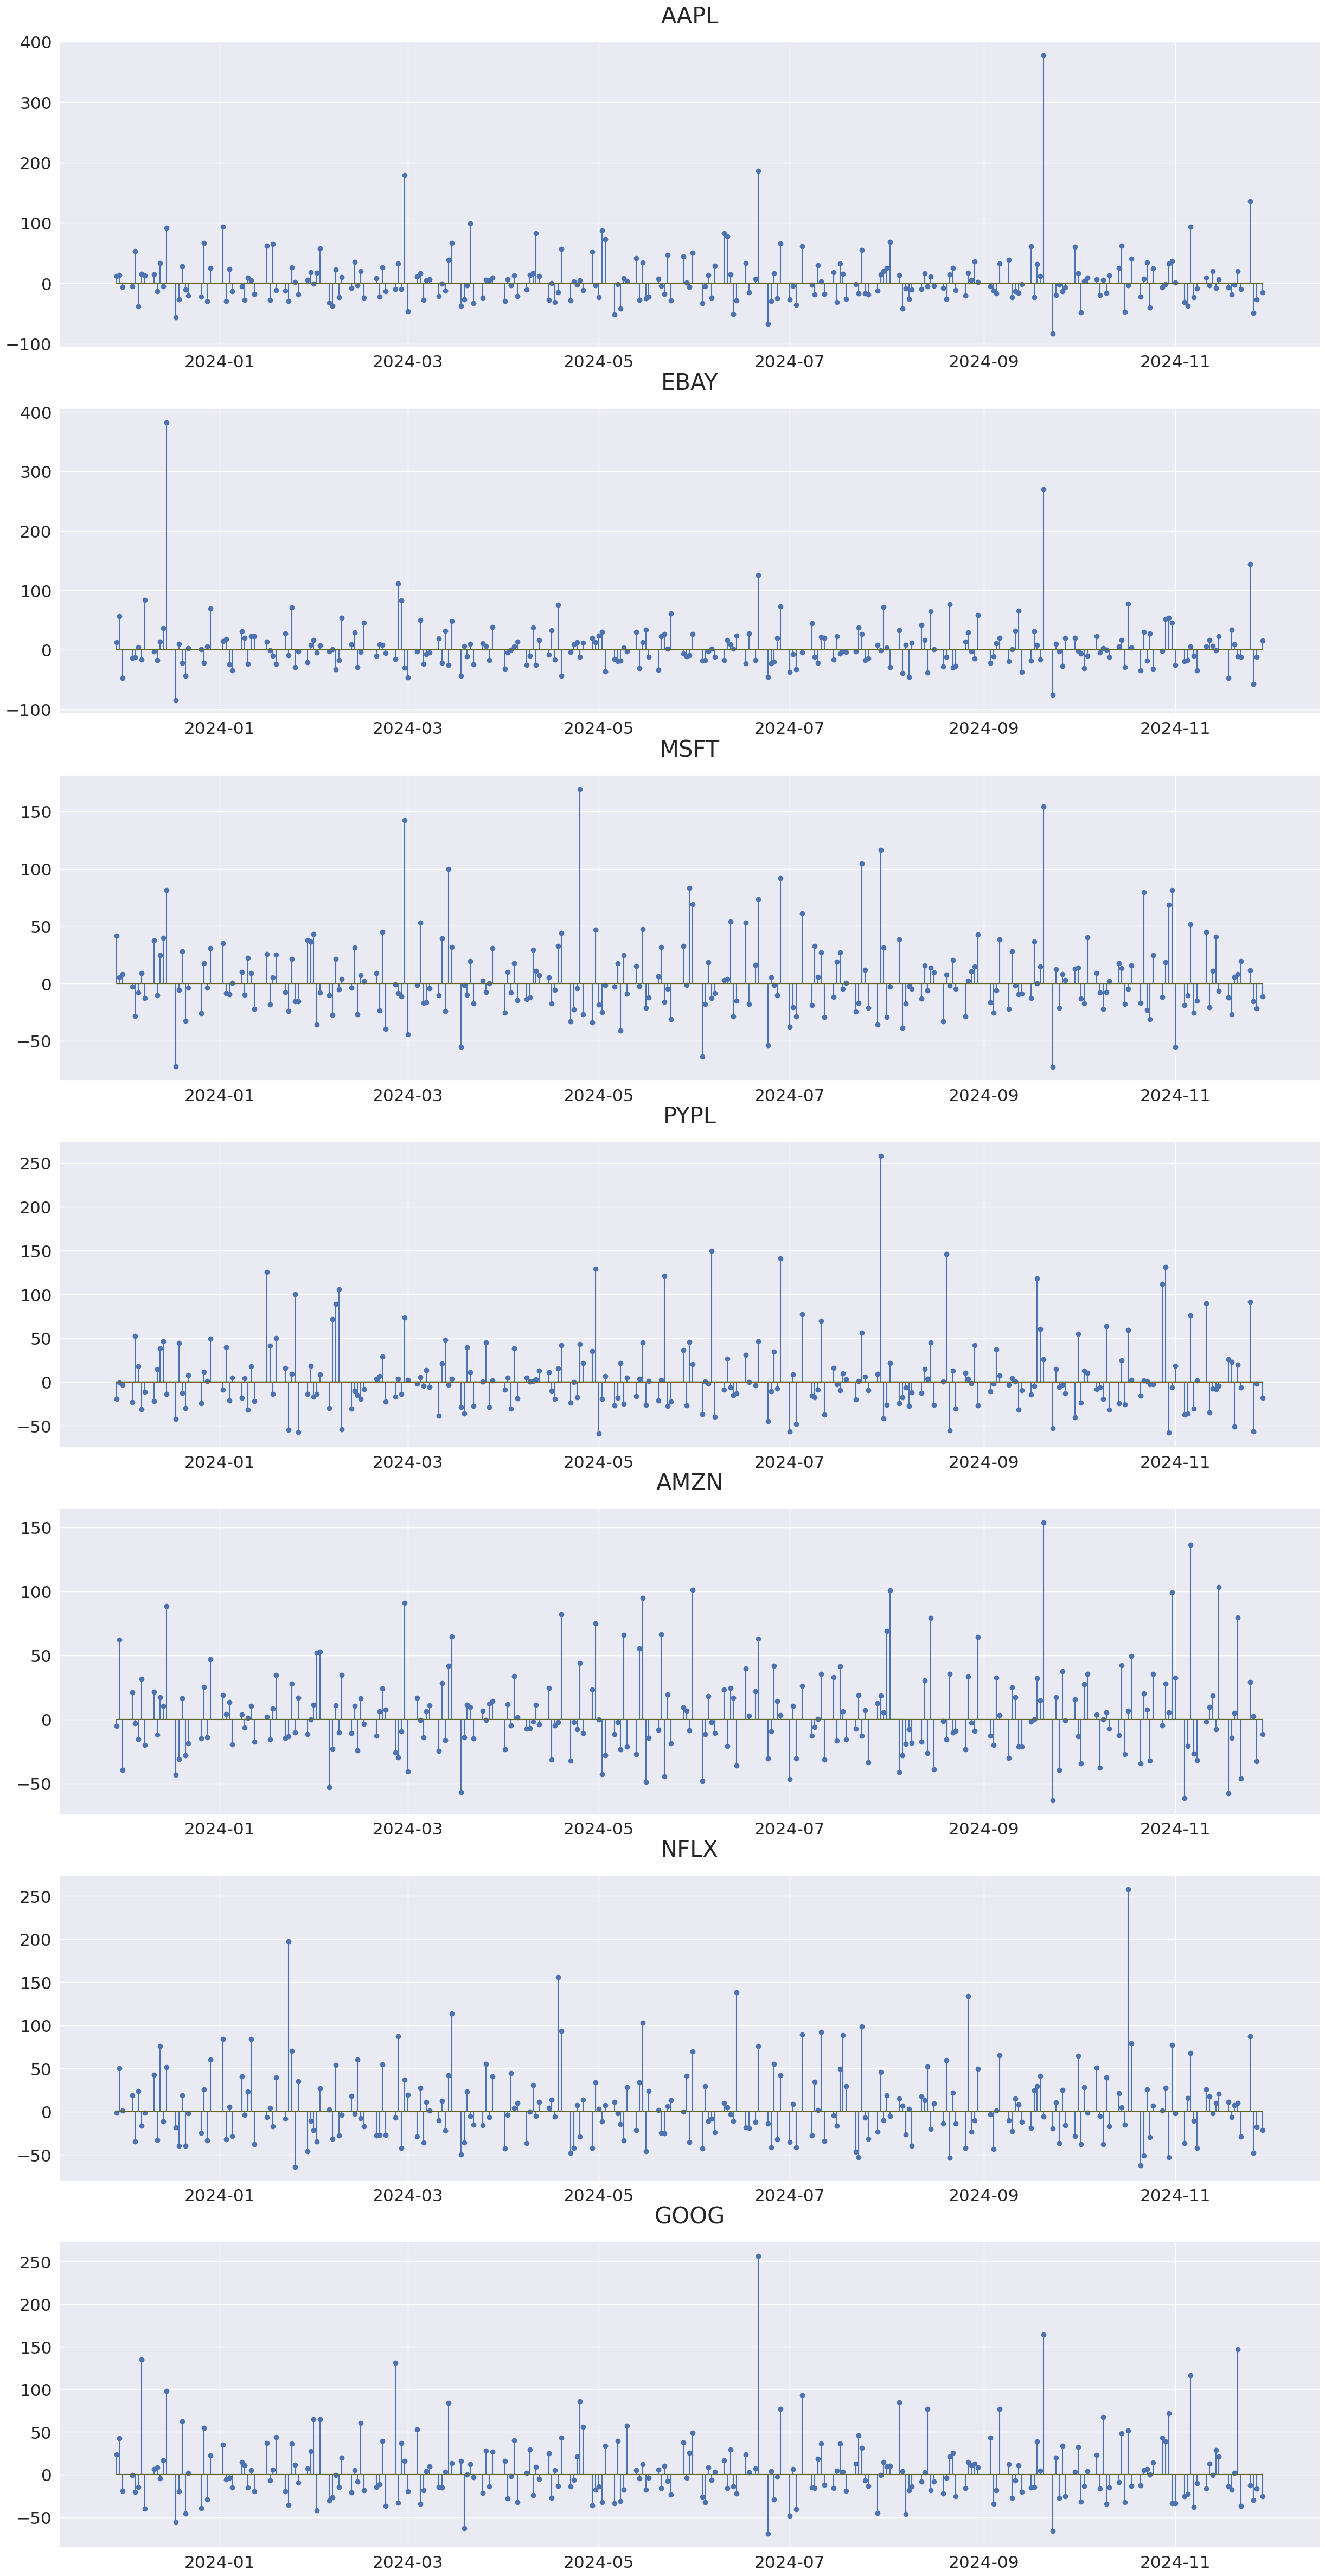

In [21]:
seaborn.set_theme(style="darkgrid")

size=30
params = {'legend.fontsize': 'small',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
fig, axs = plt.subplots(len(stock_tickers), 1, figsize=(size,size*2))

for i in range(len(stock_tickers)):
    ticker = stock_tickers[i]
    ticker_vol_chg = stock_tickers[i] + '_vol_chg'
    ticker_vol = stock_tickers[i] + '_vol'
    axs[i].stem(stock_df.index[-253:], stock_df[ticker_vol_chg][-253:])
    axs[i].plot((stock_df[ticker_vol] / 10**9)[-253:], color = 'green', alpha = 0.5)
    axs[i].set_title(ticker)


# Разложение временного ряда по компонентам

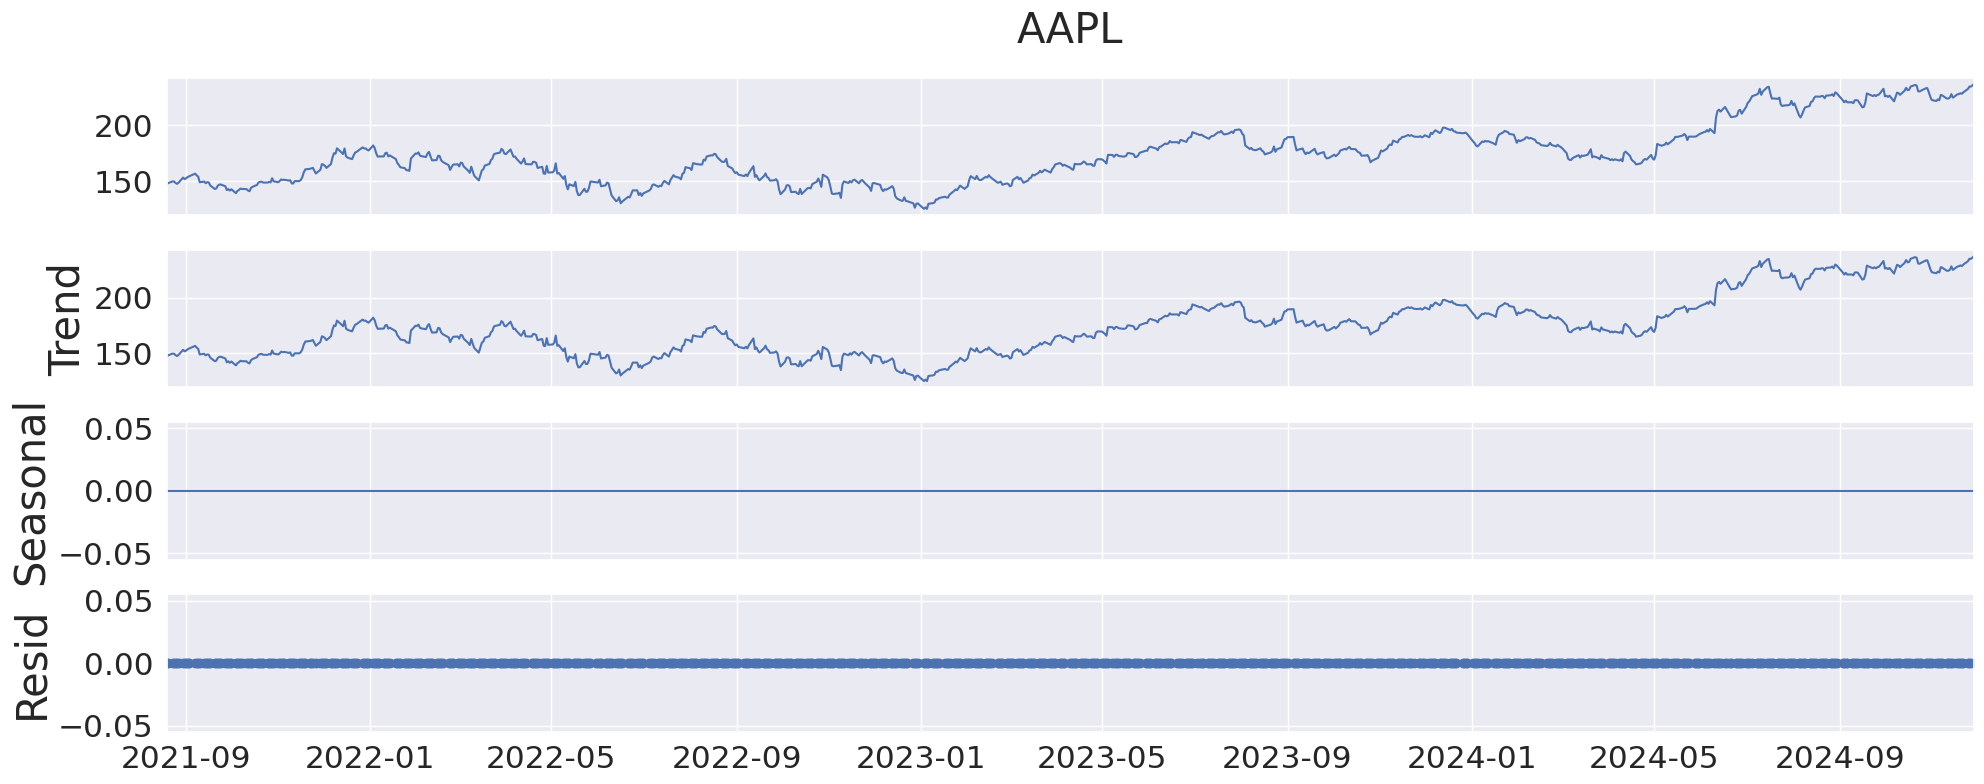

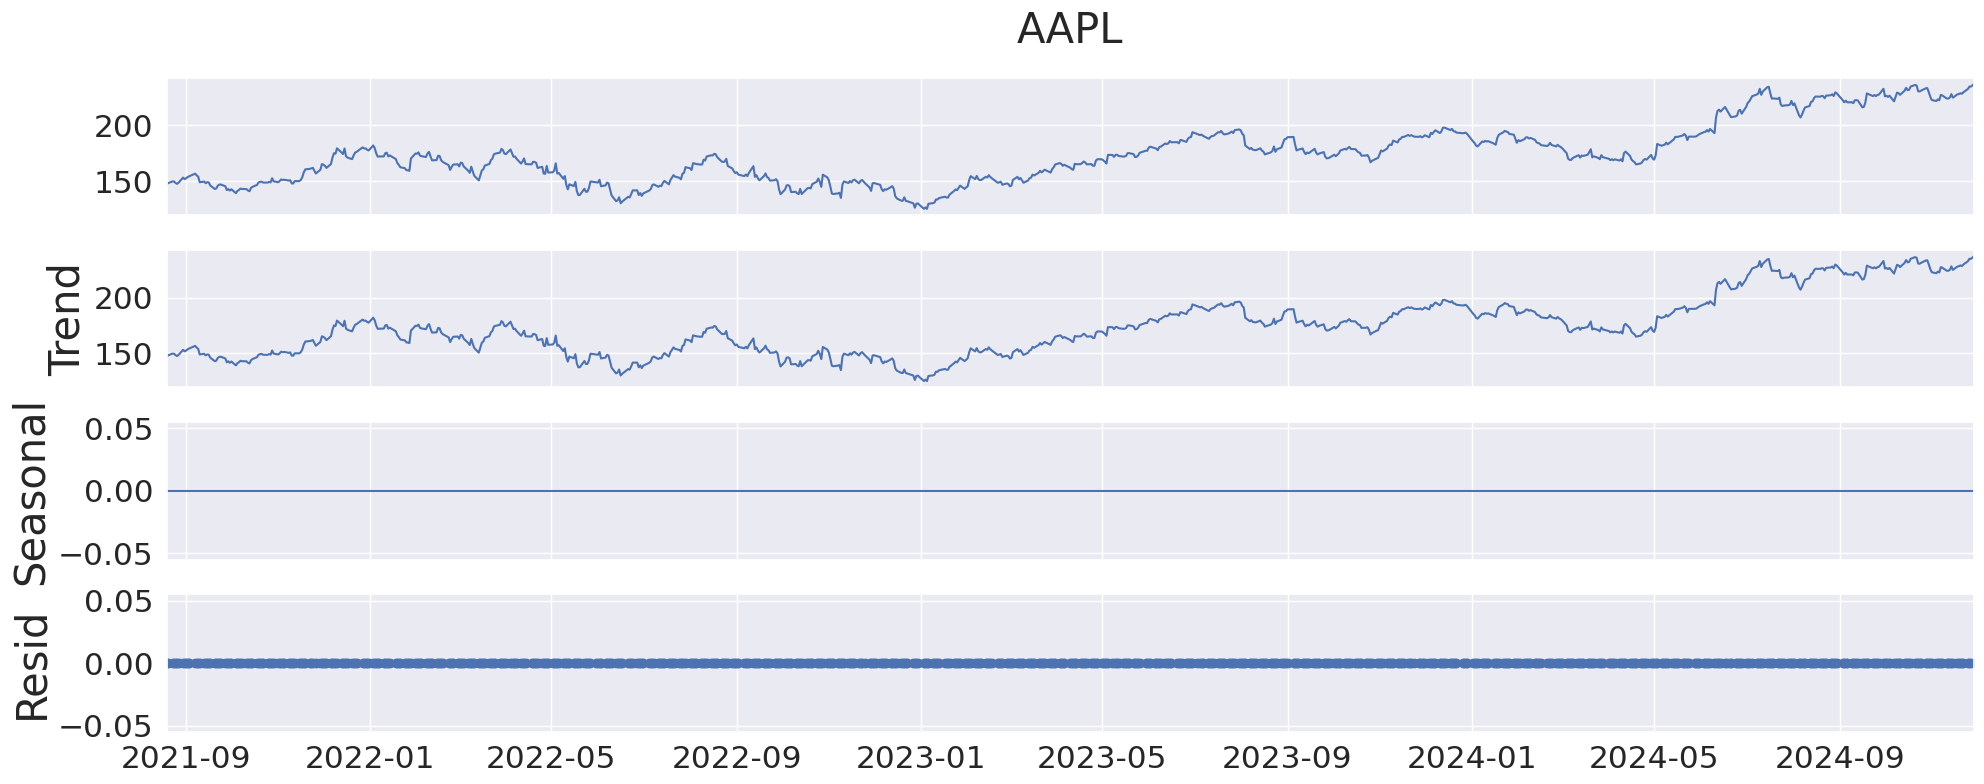

In [22]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(x=stock_df['AAPL'], model='additive', extrapolate_trend='freq', period=1)
# decomposition = sm.tsa.seasonal_decompose(stock_df['MSFT'], model='additive', extrapolate_trend='freq', period=1)
decomposition.plot()
